# Linear Method Final

First we load the data set and remove the SWEETORSOUR predictor which is not useful and transform the catergorical variables into numerical ones. We also remove predictors with null variance.

In [2]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))] #to remove the SWEETORSOUR response variable
data$Intensity<-as.numeric(as.factor(data$Intensity)) #more efficient, this way we only have one column with 2=high, 1=low
data<-data[ , which(apply(data, 2, var) != 0)] #remove all columns with variance=0 (1842 columns)


We can then separate the data set into a training and validation set (here called test set) and separate them into predictors and prediction as well as dataframe and matrix (for computational purposes).

In [3]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

#data.train
data.train.y<-data.train$VALENCE.PLEASANTNESS
data.train.x<-data.train[,-(which(names(data.train) %in% c("VALENCE.PLEASANTNESS")))]
data.train.x.matrix<- as.matrix(data.train.x) #useful for some methods

#data.test
data.test.x<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x.matrix<- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y<-data.test$VALENCE.PLEASANTNESS

## je n'ai pas inclu le calcul des corrélations, est-ce qu'on le met?

As a baseline model and to see the result of the simplest model, we perform a simple linear regression on the data set, taking into account all the predictors and no regularizers.

In [8]:
#Linear regression on the data set with the test and training errors

set.seed(199)
lm.fit <- lm(VALENCE.PLEASANTNESS ~ ., data.train)
RSS = sum((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2)
print(paste0("RSS on test set: ",RSS))
RMSE=sqrt(mean((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2))
print(paste0("RMSE on the test set:",RMSE))
summary(lm.fit)

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] "RSS on test set: 1392538778191.36"


Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] "RMSE on the test set:62719.4177438095"



Call:
lm(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.022  -1.907   0.000   1.522  46.652 

Coefficients: (2776 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)  
(Intercept)             1.119e+08  6.241e+07   1.793   0.0760 .
Intensity               2.044e+00  2.907e+00   0.703   0.4835  
complexity.from.pubmed -8.953e+01  4.345e+01  -2.061   0.0419 *
MW                     -2.843e+04  1.665e+04  -1.707   0.0908 .
AMW                    -4.267e+05  2.333e+05  -1.829   0.0703 .
Sv                      7.638e+06  4.219e+06   1.810   0.0732 .
Se                      7.733e+06  4.225e+06   1.831   0.0701 .
Sp                     -1.929e+06  1.056e+06  -1.827   0.0707 .
Si                      3.347e+06  1.865e+06   1.795   0.0756 .
Mv                      1.060e+07  5.811e+06   1.824   0.0712 .
Me                      3.446e+05  1.509e+05   2.284   0.0245 *
Mp            

# potentiel problem de colinéarité, attention au warning

As we can see, the test error obtained is extremely high and the linear fit is not a suitable approach. We will thus use more regularized approaches.A possible method is lasso regularization where the parameters are constrained. To choose the best lambda parameter (that is the strength of the regularization) we perform cross-validation on the different lambdas and choose the one with the best performances for our model.

[1] "RMSE on the training set: 19.3001854063458"
[1] "RMSE on the test set: 22.5701209247349"


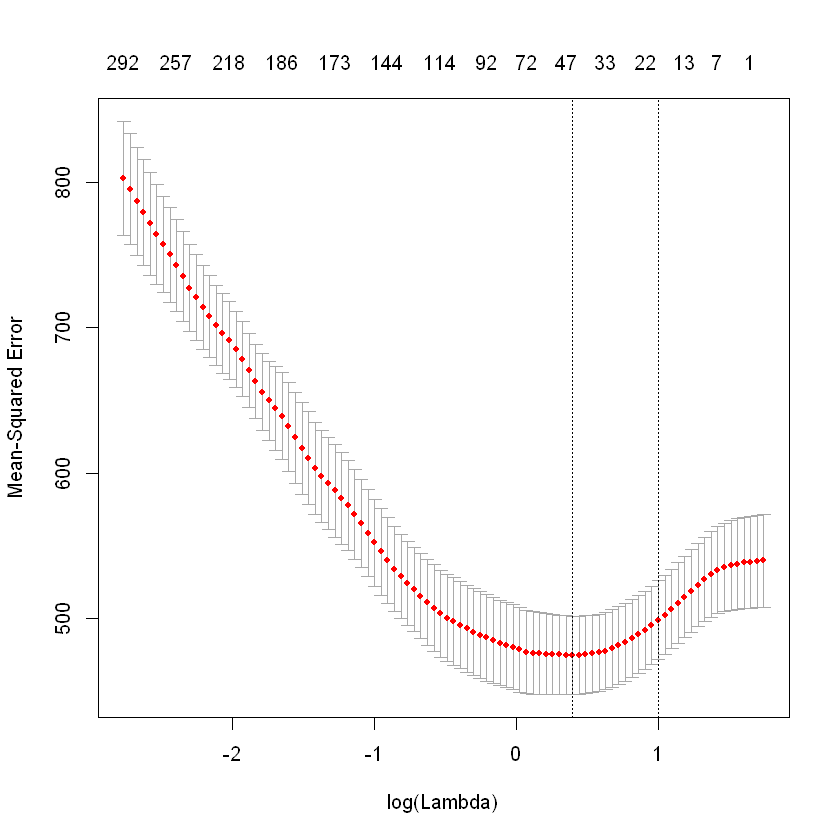

In [11]:
#Cross-validation Lasso 
set.seed(12)
#install.packages('glmnet')
library(glmnet)

#cross-validation lasso on training set
cv.lasso <- cv.glmnet(data.train.x.matrix, data.train.y, alpha = 1)
plot(cv.lasso)
best.lasso <- glmnet(data.train.x.matrix, data.train.y, alpha = 1, lambda = cv.lasso$lambda.min)
coeffs<-coef(best.lasso)

y<-predict(best.lasso,data.train.x.matrix)
RMSE.train=sqrt(mean((y-data.train.y)**2))
print(paste0("RMSE on the training set: ",RMSE.train))

y<-predict(best.lasso, data.test.x.matrix)
RMSE.test=sqrt(mean((y-data.test.y)**2))
print(paste0("RMSE on the test set: ", RMSE.test))

And similary using Ridge regression where the square of the parameters are constrained and with the same method to choose the optimal lambda.


[1] "RMSE for training set: 18.7726252859476"
[1] "RMSE for test set: 22.5009722975498"


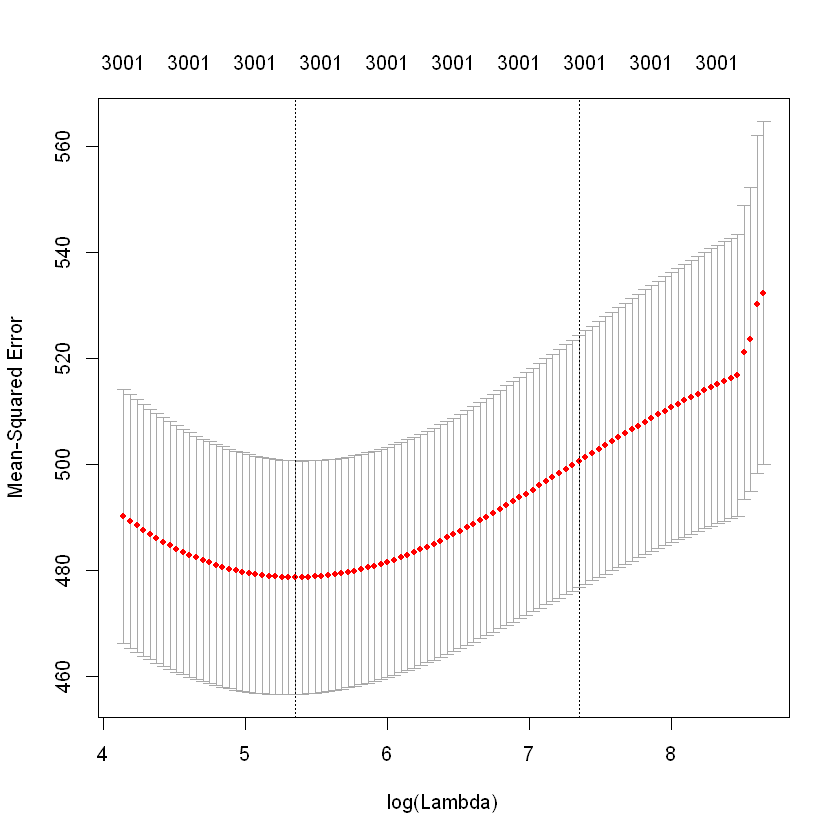

In [13]:
#Same process using Ridge regularization
set.seed(12)

#cross-validation ridge on training set
cv.ridge <- cv.glmnet(data.train.x.matrix, data.train.y, alpha = 0)
plot(cv.ridge)
best.ridge <- glmnet(data.train.x.matrix, data.train.y, alpha = 0, lambda = cv.ridge$lambda.min)
coeffs<-coef(best.ridge)

#use model on training data set
y<-predict(best.ridge,data.train.x.matrix)
RMSE.train=sqrt(mean((y-data.train.y)**2))
print(paste0("RMSE for training set: ",RMSE.train))

#test ridge regularization on test set
y<-predict(best.ridge, data.test.x.matrix)
RMSE.test=sqrt(mean((y-data.test.y)**2))
print(paste0("RMSE for test set: ",RMSE.test))

In [ ]:
Since we observed in the exploration part that some predictors seemed to be highly correlated, we will now try using the bootstrap approach which help 

In [18]:
###Define the model

bootstrap<-function(data) data[sample(nrow(data),nrow(data),replace=T),]

fitted.coefficients.ridge <- function(data){
    #prepare data
    datax<-as.matrix(data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))])
    #datax<- model.matrix(~.-1, datax)
    datay<-data$VALENCE.PLEASANTNESS

    cv.ridge <- cv.glmnet(datax, datay, alpha = 0) #0 is ridge, have to change the name of the method
    best.ridge <- glmnet(datax, datay, alpha = 0, lambda = cv.ridge$lambda.min)
    return(as.matrix(coef(best.ridge)))
}

bias_input <- function(X) cbind(rep(1, ifelse(is.null(nrow(X)), length(X), nrow(X))), X)

#number of bootstrap dataset
B=6
summary_bootstrap_withplot<-function(B, data.boot){#if you want to check the number of bootstrap needed
    coeffs=c()
    data.train.prep<-bias_input(data.train.x.matrix)
    coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
    y.pred<-data.train.prep%*%rowMeans(coeffs)
    RMSE_bootstrap<-sqrt(mean((y.pred-data.train.y)**2))
    plot(1,RMSE_bootstrap,xlim=c(1,B))
    for (i in 2:B){
       coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
       y.pred<-data.train.prep%*%rowMeans(coeffs)
       RMSE_bootstrap<-sqrt(mean((y.pred-data.train.y)**2))
       points(i,RMSE_bootstrap)
    }
    return (rowMeans(coeffs))
}
summary_bootstrap<-function(B,data.boot){
    coeffs=c()
    for (i in 2:B){
       coeffs=cbind(coeffs, fitted.coefficients.ridge(bootstrap(data.boot)))
    }
    return (rowMeans(coeffs))
}
beta<-summary_bootstrap(B,data.train)



#####Use the model to make predictions



#preparation of train set to fit output form
data.train.prep<-bias_input(data.train.x.matrix) #add column of 1 for the intercept

#compute train error
y.pred<-data.train.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.pred-data.train.y)**2))
print(paste0("RMSE on the training data with bootstrap: ",RMSE_bootstrap.train))

#compute test error
data.test.prep<-bias_input(data.test.x.matrix) #add column of 1 for the intercept
y.test.pred<-data.test.prep%*%beta
RMSE_bootstrap.test<-sqrt(mean((y.test.pred-data.test.y)**2))
print(paste0("RMSE on the test data with ridge regularization and bootstrap: ",RMSE_bootstrap.test))


[1] "RMSE on the training data with bootstrap: 18.1079186678875"
[1] "RMSE on the test data with ridge regularization and bootstrap: 23.0389744566162"


In the end this approach gives slightly better results, depending on the run, on the training data but generally not significantly better on the test set.